
**Практика 2: Исследование атак на модели ИИ. Fast Gradient Sign Method (FGSM)**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0878
Test accuracy on clean images: 0.9768000245094299


Шаг 2-3: Реализация атаки FGSM

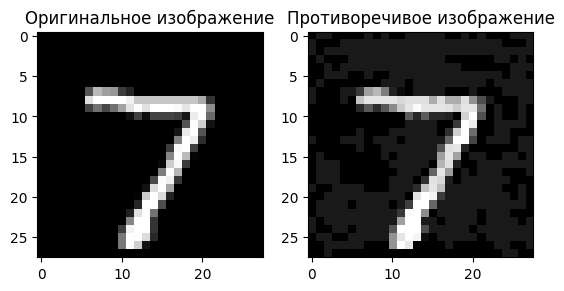

In [2]:
import numpy as np

# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
  # Применение знака градиента к изображению
  perturbed_image = image + epsilon * np.sign(gradient)
  # Обрезка значений, чтобы они оставались в пределах [0,1]
  perturbed_image = np.clip(perturbed_image, 0, 1)
  return perturbed_image

# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    # Превращаем изображение в формат, подходящий для модели
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))

    # Если label — это one-hot вектор, преобразуем его в индекс
    if len(label.shape) > 1 and label.shape[1] > 1:
        label = np.argmax(label)
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)

    gradient = tape.gradient(loss, image)

    # Применяем FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return np.reshape(adversarial_image, (28, 28, 1))

# Пример использования
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Вывод результатов
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

Шаг 4: Оценка модели на противоречивых примерах

In [3]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28, 28))

    adversarial_images = np.array(adversarial_images)

    return adversarial_images

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on a small subset of adversarial examples: {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1016 - loss: 6.4146
Accuracy on a small subset of adversarial examples: 0.12200000137090683


Шаг 5: Сравнение результатов

Test accuracy on clean images: 0.9768
Accuracy on adversarial examples: 0.1220
Accuracy reduction on adversarial examples: 0.8548


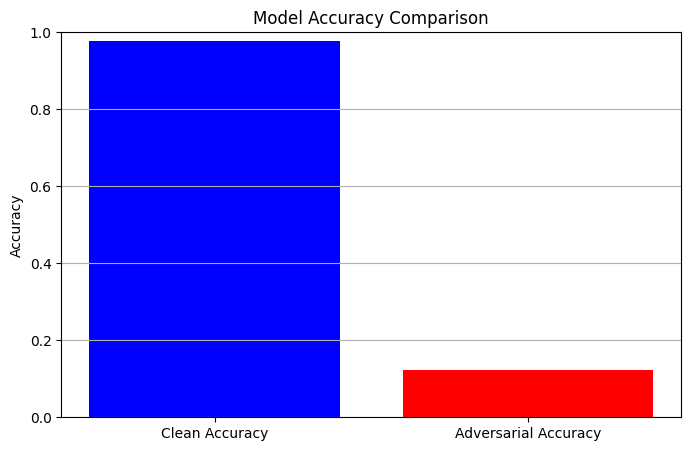

In [4]:
# Сравнение точности
print(f'Test accuracy on clean images: {test_acc:.4f}')
print(f'Accuracy on adversarial examples: {adversarial_acc:.4f}')
accuracy_reduction = test_acc - adversarial_acc
print(f'Accuracy reduction on adversarial examples: {accuracy_reduction:.4f}')

# Графическое представление результатов
labels = ['Clean Accuracy', 'Adversarial Accuracy']
accuracies = [test_acc, adversarial_acc]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'red'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y')
plt.show()